# Turkish News

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import json
import pickle

from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report

from src.utils import get_project_config
from src.utils import missing_values
import time
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')
%matplotlib inline

<Figure size 800x600 with 0 Axes>

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

#### Set Path and Constant Values

In [4]:
# Set Constants
ROOT_PATH = os.getcwd()
CFG_PATH = os.path.join(ROOT_PATH, 'cfg')
DATA_PATH = os.path.join(ROOT_PATH, 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
EMBEDDING_DATA_PATH = os.path.join(DATA_PATH, 'embedding')

os.makedirs(RAW_DATA_PATH, exist_ok=True)
# os.makedirs(EMBEDDING_DATA_PATH, exist_ok=True)

### Embedding Models

In [5]:
embedding_models = [
    'sentence-transformers/all-MiniLM-L12-v2',
    "jinaai/jina-embeddings-v3",
    "intfloat/multilingual-e5-large-instruct",
    "BAAI/bge-m3",
    "thenlper/gte-large"
]

embedding_models_dict = {
    "All Mini LM L12 v2": "sentence-transformers/all-MiniLM-L12-v2",
    "Jina Embeddings v3": "jinaai/jina-embeddings-v3",
    "Int Float Multilingual E5 Large Instruct": "intfloat/multilingual-e5-large-instruct",
    "BAAI BGE M3": "BAAI/bge-m3",
    "Thenlper Gte Large" : "thenlper/gte-large"
}

## Import Dataset: Turkish News Datasets

In [6]:
df_news_data = pd.read_csv(os.path.join(RAW_DATA_PATH, "tr_news_data.csv.gz"), compression='gzip')
df_news_data[['Ozet', 'Kategori']].head(3)

Ozet  \
0  Buckingham Sarayı’ndan, Atatürk’ün özel koleksiyonuna kadar kıymetli birçok halı Aksaray’ın Sultanhanı ilçesinde tamir ediliyor. Ünü ülke sınırlarını aşan ilçe, halı tamiri işinde dünyanın en gözde adresi...   
1                                                                                                                       Malatya'da trambüse çarpan hafif ticari araçtaki 3 yaşındaki çocuk öldü, 2 kişi yaralandı.   
2                   Yargıtay Ceza Genel Kurulu, Ankara Seferberlik Bölge Başkanlığının "kozmik odaları"nda günlerce süren aramalarla devam eden soruşturmada görev alan hakim ve savcılara verilen cezaları onadı.   

  Kategori  
0    Yaşam  
1  Türkiye  
2   Gündem

In [7]:
df_emb_data_1 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_sentence-transformers__all-MiniLM-L12-v2_embeddings.csv.gz"), compression='gzip')
df_emb_data_1.head(3)

Ozet  \
0                                                                                                          İstanbul'da polis ekipleri, usulsüz çakar-siren tertibatı kullanımı ve emniyet şeridi ihlaline yönelik denetim gerçekleştirdi.   
1                                                                                   İsrail Savunma Bakanı Yoav Gallant'ın, Gazze'de çok uluslu güç oluşturulması konusunda ABD'de yaptığı görüşmelerde ilerleme kaydedildiği öne sürüldü.   
2  Avrupa Birliği (AB) Dış İlişkiler ve Güvenlik Politikası Yüksek Temsilcisi Josep Borrell, İsrail'in Gazze'ye yönelik saldırılarında yaşanan sivil kayıplara tepki gösteren ülkelere, İsrail'e silah ihracatını durdurma çağrısı yaptı.   

  Kategori  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0  Türkiye     0.039754    -0.036171    -0.051131     0.030649     0.035366   
1    Dünya    -0.007954    -0.041042    -0.028185    -0.003145     0.033532   
2    Dünya     0.065903    -0.031213    -0.040211     0.008169     0.034982   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
0    -0.072136     0.082320     0.020445     0.012996    -0.009255   
1    -0.033909     0.039189    -0.032700     0.025830    -0.052494   
2    -0.011532     0.070105    -0.006919    -0.020165     0.001494   

   embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  \
0     -0.053810     -0.007135     -0.106906      0.030272      0.007415   
1     -0.011927      0.011093     -0.072239     -0.031187      0.023006   
2     -0.057423      0.038403     -0.092811     -0.017439      0.037792   

   embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  \
0     -0.071318     -0.055464     -0.032624     -0.056199     -0.038934   
1     -0.042807      0.008090      0.065034     -0.034021     -0.073212   
2     -0.029186     -0.017183     -0.007972     -0.034532     -0.027603   

   embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  \
0      0.067041      0.053318      0.049921     -0.021141     -0.024045   
1      0.018458      0.017453      0.045363      0.023668      0.005787   
2      0.016907     -0.040958      0.011635     -0.018340     -0.024406   

   embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  \
0     -0.050956     -0.001818     -0.041458      0.000305     -0.014939   
1     -0.052890      0.026304     -0.080971      0.041137      0.052774   
2     -0.056411      0.034339      0.009019      0.004198      0.012692   

   embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  \
0     -0.032701      0.011410      0.040199      0.083746     -0.001144   
1     -0.014521     -0.057982      0.081974      0.036472     -0.042036   
2      0.008036     -0.035874      0.053932      0.029698      0.007574   

   embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  \
0     -0.001136      0.025621      0.097771      0.002070      0.019044   
1      0.085813      0.020619      0.047542     -0.015819     -0.006490   
2      0.032033      0.058286      0.050327      0.072833     -0.006793   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0      0.008955     -0.028416     -0.011673      0.012074      0.016729   
1      0.020879     -0.071748      0.014935     -0.024192      0.079253   
2      0.046543     -0.062361     -0.015253     -0.034890      0.002878   

   embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  \
0     -0.051937     -0.018460     -0.025835      0.019039     -0.023937   
1     -0.036002     -0.033195     -0.019056      0.051735     -0.032411   
2     -0.004439      0.018277     -0.035174      0.024918     -0.048412   

   embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  \
0     -0.094623     -0.077237     -0.029917      0.019748      0.034893   
1     -0.038714     -0.062953     -0.050160     -0.056912      0.041814   
2     -0.106554     -0.067314     -0.060199     -

In [8]:
df_emb_data_2 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_jinaai__jina-embeddings-v3_embeddings.csv.gz"), compression='gzip')
df_emb_data_2.head(3)

Ozet  \
0                                                                                                          İstanbul'da polis ekipleri, usulsüz çakar-siren tertibatı kullanımı ve emniyet şeridi ihlaline yönelik denetim gerçekleştirdi.   
1                                                                                   İsrail Savunma Bakanı Yoav Gallant'ın, Gazze'de çok uluslu güç oluşturulması konusunda ABD'de yaptığı görüşmelerde ilerleme kaydedildiği öne sürüldü.   
2  Avrupa Birliği (AB) Dış İlişkiler ve Güvenlik Politikası Yüksek Temsilcisi Josep Borrell, İsrail'in Gazze'ye yönelik saldırılarında yaşanan sivil kayıplara tepki gösteren ülkelere, İsrail'e silah ihracatını durdurma çağrısı yaptı.   

  Kategori  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0  Türkiye     0.044678     0.015503     0.033936     0.125977     0.096680   
1    Dünya     0.091797    -0.070801     0.014343    -0.019775     0.020508   
2    Dünya     0.046875    -0.035156    -0.009644    -0.020142     0.099121   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
0     0.050293    -0.019287     0.091309    -0.039307     0.067383   
1    -0.052979     0.004608     0.028076    -0.016235    -0.054199   
2    -0.043457     0.135742     0.058838     0.057129     0.108398   

   embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  \
0     -0.056641      0.126953     -0.016113      0.059814      0.045654   
1      0.050049      0.059814      0.001678     -0.076172     -0.013245   
2      0.083008      0.037598     -0.008301     -0.137695      0.042480   

   embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  \
0     -0.092285     -0.023926     -0.002869      0.011597      0.045166   
1      0.038330     -0.107422      0.002121      0.030884     -0.069336   
2     -0.069336     -0.049805     -0.086426     -0.113281     -0.050537   

   embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  \
0     -0.031250      0.029297     -0.075684      0.004761      0.055420   
1      0.023682     -0.010559     -0.068359      0.117676      0.012024   
2      0.078613      0.009583     -0.067383      0.078613     -0.039795   

   embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  \
0     -0.017456     -0.003235      0.044678     -0.052979      0.227539   
1      0.151367     -0.091309      0.097168      0.149414      0.034424   
2      0.069336     -0.094238      0.039062      0.018066      0.008179   

   embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  \
0      0.018188      0.014709     -0.020386      0.028809      0.000341   
1      0.081055      0.076172      0.045898     -0.023926     -0.030884   
2      0.007294      0.070312      0.030151      0.002274     -0.030151   

   embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  \
0      0.104492      0.031982      0.019531      0.000717      0.001778   
1      0.078613      0.008484     -0.040283     -0.025269     -0.008606   
2      0.158203     -0.044189     -0.034424     -0.059570      0.060059   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0     -0.002945     -0.062012      0.085449     -0.016479     -0.041992   
1      0.018677      0.043457     -0.063477     -0.007202      0.071777   
2     -0.039795     -0.019531      0.006927     -0.064941      0.045654   

   embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  \
0      0.002182      0.125977     -0.051270      0.014832      0.024536   
1      0.030273     -0.050049      0.008240      0.031006      0.027832   
2      0.070312     -0.040283      0.054199      0.004425      0.003906   

   embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  \
0       0.01062     -0.006134      0.042969     -0.104492     -0.053711   
1       0.00824     -0.026611      0.031738      0.123535      0.045410   
2      -0.05127     -0.029175      0.009277     -

In [9]:
df_emb_data_3 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_intfloat__multilingual-e5-large-instruct_embeddings.csv.gz"), compression='gzip')
df_emb_data_3.head(3)

Ozet  \
0                                                                                                          İstanbul'da polis ekipleri, usulsüz çakar-siren tertibatı kullanımı ve emniyet şeridi ihlaline yönelik denetim gerçekleştirdi.   
1                                                                                   İsrail Savunma Bakanı Yoav Gallant'ın, Gazze'de çok uluslu güç oluşturulması konusunda ABD'de yaptığı görüşmelerde ilerleme kaydedildiği öne sürüldü.   
2  Avrupa Birliği (AB) Dış İlişkiler ve Güvenlik Politikası Yüksek Temsilcisi Josep Borrell, İsrail'in Gazze'ye yönelik saldırılarında yaşanan sivil kayıplara tepki gösteren ülkelere, İsrail'e silah ihracatını durdurma çağrısı yaptı.   

  Kategori  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0  Türkiye     0.028065     0.024589    -0.003297    -0.049114     0.002043   
1    Dünya     0.038951     0.032010    -0.003437    -0.054996     0.013552   
2    Dünya     0.027884     0.022838    -0.005010    -0.034759     0.032932   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
0     0.014441    -0.038144     0.044304     0.026490    -0.024979   
1     0.016066     0.000595     0.060087     0.028325    -0.027362   
2     0.004581     0.002464     0.027347     0.051510    -0.022447   

   embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  \
0      0.010855      0.019827     -0.020318     -0.026813     -0.032187   
1      0.034713      0.035340     -0.058099      0.006202     -0.008497   
2      0.025961      0.024803     -0.047270     -0.003780      0.016657   

   embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  \
0     -0.063963     -0.004681      0.018607     -0.006501     -0.017709   
1     -0.026320      0.013417      0.035507      0.015073     -0.007333   
2     -0.054568      0.025573      0.010025      0.008472     -0.008322   

   embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  \
0      0.048592     -0.027656     -0.037024     -0.039842     -0.010688   
1      0.027762     -0.027404     -0.011789      0.002070     -0.009923   
2     -0.008259     -0.015823     -0.021295     -0.022587     -0.011533   

   embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  \
0     -0.013211     -0.016210     -0.022773     -0.052606     -0.031870   
1     -0.021839     -0.068835     -0.012977     -0.021281     -0.008224   
2      0.005357     -0.047344     -0.014521     -0.006518     -0.015195   

   embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  \
0     -0.003910     -0.000999     -0.022191     -0.032160     -0.047637   
1      0.005377      0.057737      0.005292     -0.019028     -0.014698   
2      0.011429      0.051687     -0.023180     -0.021262     -0.017147   

   embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  \
0      0.048930      0.029977      0.055296     -0.048727      0.070838   
1      0.057066      0.041414      0.025080     -0.035022      0.056815   
2      0.050544      0.044604      0.023758     -0.049593      0.074214   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0      0.002564      0.025995      0.004991     -0.019265     -0.009393   
1     -0.030030      0.028178     -0.004721     -0.025219     -0.005261   
2     -0.022268      0.045139     -0.019740     -0.057754      0.018612   

   embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  \
0      0.021279      0.042671     -0.009038     -0.041005      0.031865   
1      0.033851      0.014844      0.019193      0.003266      0.045173   
2      0.023838      0.047446      0.005843     -0.025102      0.026084   

   embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  \
0      0.063367      0.031781     -0.024465     -0.042734     -0.051903   
1      0.030711      0.018598     -0.028179     -0.019487     -0.017220   
2      0.012571      0.019107     -0.014357     -

In [10]:
df_emb_data_4 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_BAAI__bge-m3_embeddings.csv.gz"), compression='gzip')
df_emb_data_4.head(3)

Ozet  \
0                                                                                                          İstanbul'da polis ekipleri, usulsüz çakar-siren tertibatı kullanımı ve emniyet şeridi ihlaline yönelik denetim gerçekleştirdi.   
1                                                                                   İsrail Savunma Bakanı Yoav Gallant'ın, Gazze'de çok uluslu güç oluşturulması konusunda ABD'de yaptığı görüşmelerde ilerleme kaydedildiği öne sürüldü.   
2  Avrupa Birliği (AB) Dış İlişkiler ve Güvenlik Politikası Yüksek Temsilcisi Josep Borrell, İsrail'in Gazze'ye yönelik saldırılarında yaşanan sivil kayıplara tepki gösteren ülkelere, İsrail'e silah ihracatını durdurma çağrısı yaptı.   

  Kategori  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0  Türkiye    -0.000218     0.012435    -0.043321    -0.012619    -0.040187   
1    Dünya     0.002490     0.038941    -0.018162     0.015290    -0.005615   
2    Dünya    -0.001413     0.049454    -0.035996     0.021653    -0.019136   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
0     0.021491    -0.029449     0.050058    -0.005434     0.034502   
1     0.038379     0.056276     0.003842    -0.020123     0.003924   
2     0.001784     0.064076    -0.011606    -0.001492     0.013270   

   embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  \
0     -0.033496      0.010105     -0.003636     -0.033718     -0.006000   
1      0.012615      0.010410     -0.026830      0.010424      0.039761   
2     -0.011361      0.051767     -0.006870     -0.024645      0.065251   

   embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  \
0     -0.036806      0.066173     -0.034775      0.003427     -0.054780   
1      0.022515      0.085963      0.030068      0.014897      0.002175   
2      0.018788      0.034375     -0.007167      0.006077      0.009923   

   embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  \
0      0.007910     -0.010045      0.006055     -0.015004     -0.035468   
1     -0.017164     -0.021262     -0.014829     -0.008797     -0.002757   
2     -0.032233      0.017058     -0.036781     -0.008042     -0.018720   

   embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  \
0      0.015363      0.014342      0.014550     -0.009840      0.012398   
1     -0.024744     -0.041371     -0.040684      0.008145      0.002254   
2      0.007069      0.006252     -0.007646      0.030164      0.021827   

   embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  \
0      0.020565     -0.018940      0.033780     -0.019347     -0.044466   
1      0.040807      0.036077      0.031519      0.022493      0.005113   
2      0.009239      0.032962      0.025985      0.035766     -0.040617   

   embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  \
0     -0.022781     -0.022174     -0.003849     -0.008276      0.052171   
1      0.012118      0.019075     -0.060917     -0.036705      0.033301   
2      0.033194     -0.006710     -0.046642     -0.029455      0.050350   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0      0.050905     -0.006719      0.021357      0.002234      0.013541   
1     -0.024299      0.027021      0.004953     -0.005359      0.001461   
2     -0.044634      0.025927      0.023614     -0.080082      0.039972   

   embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  \
0     -0.034747     -0.026582     -0.020672     -0.039095      0.006783   
1     -0.006297     -0.031732      0.004514      0.038933     -0.004701   
2     -0.027912     -0.045312      0.004391     -0.022503     -0.038888   

   embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  \
0      0.041043      0.000488      0.023707     -0.036811     -0.004507   
1      0.012609     -0.016287      0.033940     -0.001010      0.027997   
2     -0.010158     -0.025188      0.042252     -

In [11]:
df_emb_data_5 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_thenlper__gte-large_embeddings.csv.gz"), compression='gzip')
df_emb_data_5.head(3)

Ozet  \
0                                                                                                          İstanbul'da polis ekipleri, usulsüz çakar-siren tertibatı kullanımı ve emniyet şeridi ihlaline yönelik denetim gerçekleştirdi.   
1                                                                                   İsrail Savunma Bakanı Yoav Gallant'ın, Gazze'de çok uluslu güç oluşturulması konusunda ABD'de yaptığı görüşmelerde ilerleme kaydedildiği öne sürüldü.   
2  Avrupa Birliği (AB) Dış İlişkiler ve Güvenlik Politikası Yüksek Temsilcisi Josep Borrell, İsrail'in Gazze'ye yönelik saldırılarında yaşanan sivil kayıplara tepki gösteren ülkelere, İsrail'e silah ihracatını durdurma çağrısı yaptı.   

  Kategori  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0  Türkiye    -0.021702     0.001828    -0.013789     0.002805    -0.033859   
1    Dünya     0.001576    -0.009909    -0.007309     0.000906    -0.037807   
2    Dünya    -0.018617    -0.015325    -0.011389    -0.018034    -0.021952   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
0    -0.003653    -0.038753     0.016499     0.020792     0.020317   
1    -0.016896    -0.002285     0.017887     0.006306     0.015487   
2    -0.012184    -0.008548     0.000239    -0.000953     0.039995   

   embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  \
0      0.033035      0.012585     -0.001993     -0.025515     -0.014894   
1      0.041068     -0.010362      0.021618     -0.027552     -0.012775   
2      0.036411     -0.002082      0.012606     -0.037040     -0.022615   

   embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  \
0     -0.000441     -0.037176     -0.024728      0.008400     -0.011162   
1     -0.011987     -0.049314     -0.048618     -0.024172      0.006314   
2      0.005815     -0.024717     -0.031874      0.007794      0.009873   

   embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  \
0     -0.006593      0.003812     -0.071405     -0.061131     -0.037582   
1      0.019159     -0.002843     -0.063596     -0.026523     -0.007339   
2     -0.007575      0.005573     -0.053729     -0.016279     -0.012274   

   embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  \
0      0.026862      0.047289     -0.032843      0.048395      0.052742   
1      0.030481      0.001866     -0.021371      0.052019      0.075872   
2      0.019873      0.011364     -0.021184      0.062197      0.068877   

   embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  \
0     -0.023062     -0.025108      0.034031     -0.033560     -0.007183   
1      0.011727     -0.009318      0.014021     -0.050857     -0.004986   
2      0.001314     -0.035594      0.027569     -0.035892     -0.016428   

   embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  \
0     -0.035445      0.043153     -0.029578      0.005859     -0.045385   
1     -0.023878      0.035865     -0.040586      0.009823     -0.040205   
2     -0.035682      0.034570     -0.024070      0.005255     -0.037877   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0     -0.013693      0.002612      0.014921     -0.053718     -0.012574   
1     -0.003164     -0.023512      0.030287     -0.033209     -0.029535   
2      0.015224     -0.003649      0.014640     -0.048587     -0.033912   

   embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  \
0      0.003491      0.003958     -0.040225     -0.028645     -0.033438   
1      0.010483      0.013749     -0.072836      0.017667     -0.024559   
2     -0.008970      0.001664     -0.047918     -0.013059     -0.045140   

   embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  \
0     -0.004788      0.004182      0.030597      0.006367     -0.020163   
1      0.007897     -0.008635      0.029042     -0.016203     -0.022612   
2     -0.018218     -0.004629      0.045421     -

In [12]:
print(f"Emb. Model Name: {embedding_models[0]} & Data Shape: {df_emb_data_1.shape}")
print(f"Emb. Model Name: {embedding_models[1]} & Data Shape: {df_emb_data_2.shape}")
print(f"Emb. Model Name: {embedding_models[2]} & Data Shape: {df_emb_data_3.shape}")
print(f"Emb. Model Name: {embedding_models[3]} & Data Shape: {df_emb_data_4.shape}")
print(f"Emb. Model Name: {embedding_models[4]} & Data Shape: {df_emb_data_5.shape}")

Emb. Model Name: sentence-transformers/all-MiniLM-L12-v2 & Data Shape: (7500, 386)
Emb. Model Name: jinaai/jina-embeddings-v3 & Data Shape: (7500, 1026)
Emb. Model Name: intfloat/multilingual-e5-large-instruct & Data Shape: (7500, 1026)
Emb. Model Name: BAAI/bge-m3 & Data Shape: (7500, 1026)
Emb. Model Name: thenlper/gte-large & Data Shape: (7500, 1026)


## Modelling

### Model 1: SVM Model

#### K Fold Cross Validation

In [13]:
# K-fold Cross Validation Value 5, 10
k_fold_splits = 5

# Create K-fold object
kf = KFold(n_splits=k_fold_splits, shuffle=True, random_state=23)

#### Encoding

In [14]:
# Label Encoding

In [15]:
# print("Target Unique Values:", df_emb_data_1['Kategori'].unique())
# # df_emb_data_1['Kategori'].values
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(df_emb_data_1['Kategori'].values)

#### Split Dataset

In [16]:
# Train: 6500 & # Test: 1000

In [17]:
# feature_columns = [col for col in df_emb_data_1.columns if 'embedding_' in col]
# print("Feature Columns:", feature_columns)

# X = df_emb_data_1[feature_columns].values
# # y = df_emb_data_1['Kategori'].values
# y = y_encoded

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

#### SVM Classifier

In [18]:
label_encoder = LabelEncoder()
df_emb_data_list = [df_emb_data_1, df_emb_data_2, df_emb_data_3, df_emb_data_4, df_emb_data_5]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
1 sentence-transformers/all-MiniLM-L12-v2 - Embedding Data Shape: (7500, 386)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (384) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_379', 'embedding_380', 'embedding_381', 'embedding_382', 'embedding_383']
X Shape: (7500, 384) & y Shape: (7500,)
X_Train Shape: (6500, 384) & X_Test Shape: (1000, 384) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)

Id   Mean     StDev 					Params
1 0.777538 (0.007090) with: {'kernel': 'rbf', 'gamma': np.float64(0.46415888336127775), 'C': np.float64(0.21544346900318834)}
2 0.359385 (0.052207) with: {'kernel': 'rbf', 'gamma': np.float64(0.1668100537200059), 'C': np.float64(0.027825594022071243)}
3 0.825385 (0.010570) with: {'ker

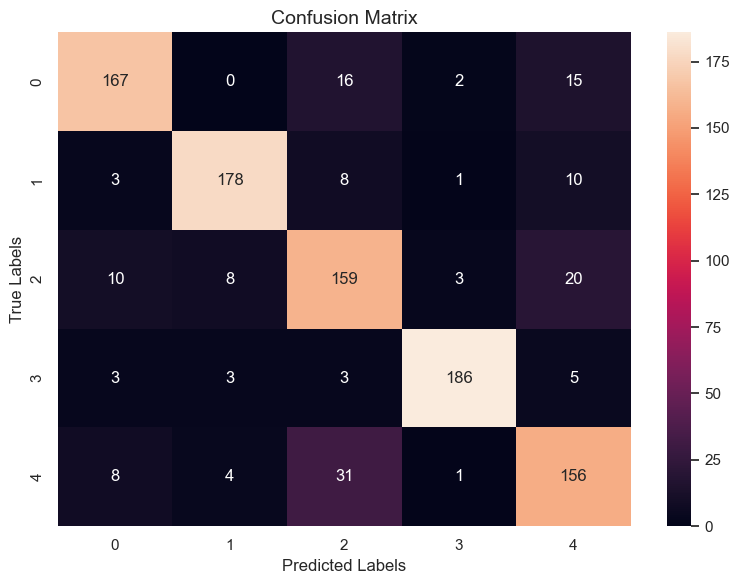

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       200
           1       0.92      0.89      0.91       200
           2       0.73      0.80      0.76       200
           3       0.96      0.93      0.95       200
           4       0.76      0.78      0.77       200

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

Test Accuracy: 0.846
Test F1 Score: 0.848
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
2 jinaai/jina-embeddings-v3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Col

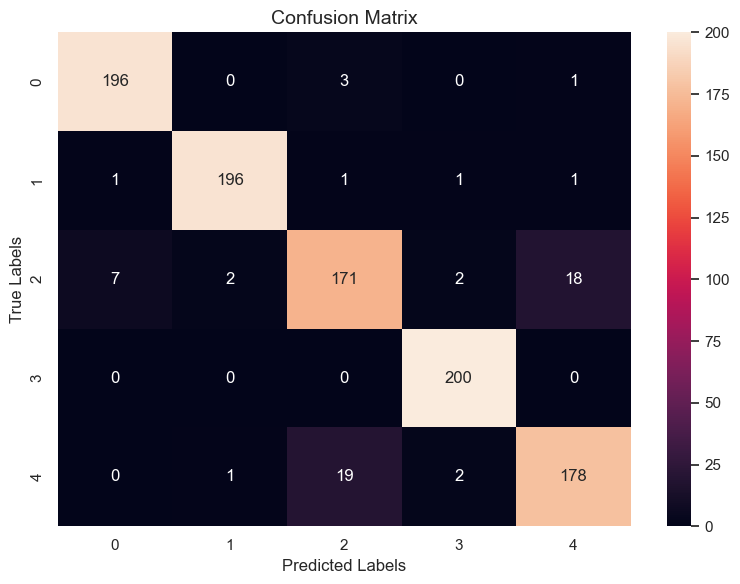

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       200
           1       0.98      0.98      0.98       200
           2       0.88      0.85      0.87       200
           3       0.98      1.00      0.99       200
           4       0.90      0.89      0.89       200

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

Test Accuracy: 0.941
Test F1 Score: 0.941
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
3 intfloat/multilingual-e5-large-instruct - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim

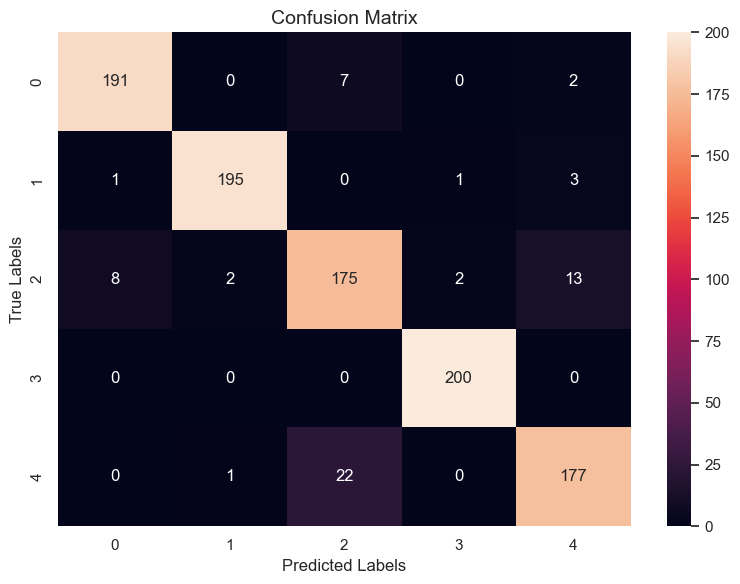

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       200
           1       0.98      0.97      0.98       200
           2       0.86      0.88      0.87       200
           3       0.99      1.00      0.99       200
           4       0.91      0.89      0.90       200

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

Test Accuracy: 0.938
Test F1 Score: 0.938
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
4 BAAI/bge-m3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (1024) &

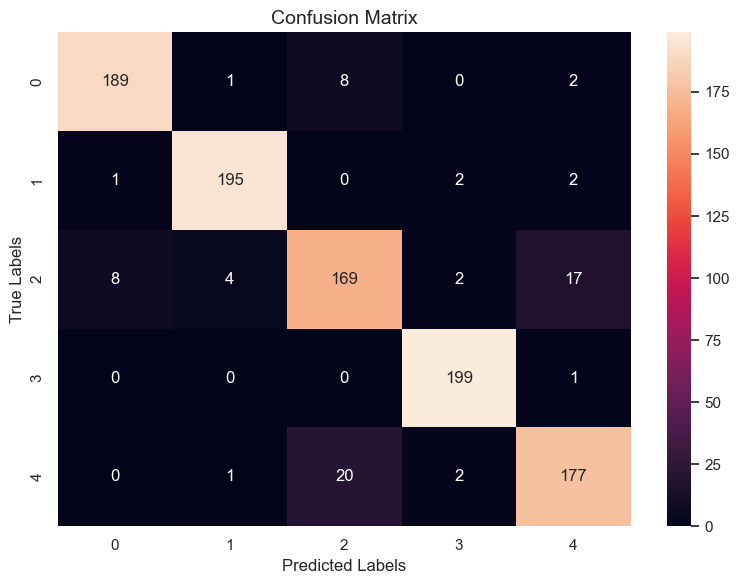

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       200
           1       0.97      0.97      0.97       200
           2       0.86      0.84      0.85       200
           3       0.97      0.99      0.98       200
           4       0.89      0.89      0.89       200

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Test Accuracy: 0.929
Test F1 Score: 0.929
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
5 thenlper/gte-large - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (

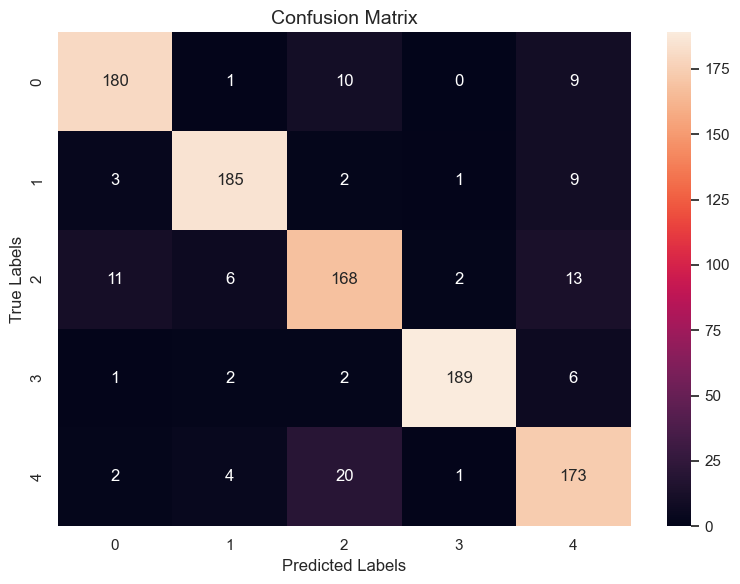

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       200
           1       0.93      0.93      0.93       200
           2       0.83      0.84      0.84       200
           3       0.98      0.94      0.96       200
           4       0.82      0.86      0.84       200

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.90      1000
weighted avg       0.90      0.90      0.90      1000

Test Accuracy: 0.895
Test F1 Score: 0.896
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
CPU times: total: 1h 23min 37s
Wall time: 1h 24min 42s


In [19]:
%%time

model_stats_svm = {}

for idx, df_emb_data in enumerate(df_emb_data_list):
    print("# " * 50)
    print(f"{idx+1} {embedding_models[idx]} - Embedding Data Shape: {df_emb_data.shape}")
    print("# " * 50)
    print("Target Unique Values:", df_emb_data['Kategori'].unique())

    feature_columns = [col for col in df_emb_data.columns if 'embedding_' in col]
    print(f"Feature Columns: ({len(feature_columns)}) & {feature_columns[0:5]} ... {feature_columns[len(feature_columns)-5:]}")

    X = df_emb_data[feature_columns].values
    # y = df_emb_data_1['Kategori'].values
    y_encoded = label_encoder.fit_transform(df_emb_data['Kategori'].values)
    y = y_encoded
    print(f"X Shape: {X.shape} & y Shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    print(f"X_Train Shape: {X_train.shape} & X_Test Shape: {X_test.shape} & Y_Train Shape: {y_train.shape} & Y_Test Shape: {y_test.shape}")

    X_train.shape, y_train.shape, X_test.shape, y_test.shape

    # Parametre Values for SVM Model
    svm_param_dist = {
        'C': np.logspace(-2, 2, 10),
        'gamma': np.logspace(-3, 1, 10),
        'kernel': ['rbf', 'linear']
    }

    # SVM Classifier Model
    svm_clf = SVC()

    # SVM Model with Random Search
    svm_random_model = RandomizedSearchCV(estimator=svm_clf,
                                          param_distributions=svm_param_dist,
                                          n_iter=10,
                                          cv=kf,
                                          scoring='accuracy',
                                          random_state=23)

    svm_model = svm_random_model.fit(X_train, y_train)

    svm_random_model_best_estimator = svm_model.best_estimator_
    svm_random_model_best_params = svm_model.best_params_
    svm_random_model_best_score = svm_model.best_score_

    # Model Performans Evaluate
    # svm_random_scores = cross_val_score(svm_random_model_best_estimator, X_train, y_train, cv=kf, scoring='accuracy')

    means = svm_model.cv_results_['mean_test_score']
    stds = svm_model.cv_results_['std_test_score']
    params = svm_model.cv_results_['params']

    print()
    print("Id", "  Mean", "    StDev", "\t\t\t\t\tParams")
    for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

    # Summarize Results
    print()
    print("Best: %f using %s" % (svm_random_model_best_score, svm_random_model_best_params))
    print()

    y_pred = svm_random_model_best_estimator.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g');
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

    # Set labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()    

    print("Classification Report:")
    print(classification_report(y_true=y_test, y_pred=y_pred))

    acc_score = round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)
    f1_score_ = round(f1_score(y_true=y_test, y_pred=y_pred, average='macro'), 3)
    print("Test Accuracy:", acc_score)
    print("Test F1 Score:", f1_score_)
    
    model_stats_svm[f"Emb_{idx+1}"] = {
        "train_best_score": svm_random_model_best_score,
        "train_best_params": svm_random_model_best_params,
        "test_accuracy": acc_score,
        "test_f1": f1_score_,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    print("* " * 50)

### Model 2: Random Forest Model

In [21]:
%%time

model_stats_rf = {}

for idx, df_emb_data in enumerate(df_emb_data_list):
    print("# " * 50)
    print(f"{idx+1} {embedding_models[idx]} - Embedding Data Shape: {df_emb_data.shape}")
    print("# " * 50)
    print("Target Unique Values:", df_emb_data['Kategori'].unique())

    feature_columns = [col for col in df_emb_data.columns if 'embedding_' in col]
    print(f"Feature Columns: ({len(feature_columns)}) & {feature_columns[0:5]} ... {feature_columns[len(feature_columns)-5:]}")

    X = df_emb_data[feature_columns].values
    # y = df_emb_data['Kategori'].values
    y_encoded = label_encoder.fit_transform(df_emb_data['Kategori'].values)
    y = y_encoded
    print(f"X Shape: {X.shape} & y Shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    print(f"X_Train Shape: {X_train.shape} & X_Test Shape: {X_test.shape} & Y_Train Shape: {y_train.shape} & Y_Test Shape: {y_test.shape}")

    X_train.shape, y_train.shape, X_test.shape, y_test.shape

    # Parametre Values for RF Model
    rf_param_dist = {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [10, 20, 30, 50, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'bootstrap': [True, False],
    }

    # RF Classifier Model
    rf_clf = RandomForestClassifier()

    # RF Model with Random Search
    rf_random_model = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=rf_param_dist,
        n_iter=10,
        scoring='accuracy',
        cv=kf,
        verbose=2,
        random_state=23,
        # n_jobs=-1
    )

    rf_model = rf_random_model.fit(X_train, y_train)

    rf_random_model_best_estimator = rf_model.best_estimator_
    rf_random_model_best_params = rf_model.best_params_
    rf_random_model_best_score = rf_model.best_score_

    means = rf_model.cv_results_['mean_test_score']
    stds = rf_model.cv_results_['std_test_score']
    params = rf_model.cv_results_['params']

    print()
    print("Id", "  Mean", "    StDev", "\t\t\t\t\tParams")
    for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

    # Summarize Results
    print()
    print("Best: %f using %s" % (rf_random_model_best_score, rf_random_model_best_params))
    print()

    y_pred = rf_random_model_best_estimator.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g');
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

    # Set labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()    

    print("Classification Report:")
    print(classification_report(y_true=y_test, y_pred=y_pred))

    acc_score = round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)
    f1_score_ = round(f1_score(y_true=y_test, y_pred=y_pred, average='macro'), 3)
    print("Test Accuracy:", acc_score)
    print("Test F1 Score:", f1_score_)
    
    model_stats_rf[f"Emb_{idx+1}"] = {
        "train_best_score": rf_random_model_best_score,
        "train_best_params": rf_random_model_best_params,
        "test_accuracy": acc_score,
        "test_f1": f1_score_,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    print("* " * 50)
    # break

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
1 sentence-transformers/all-MiniLM-L12-v2 - Embedding Data Shape: (7500, 386)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
Feature Columns: (384) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_379', 'embedding_380', 'embedding_381', 'embedding_382', 'embedding_383']
X Shape: (7500, 384) & y Shape: (7500,)
X_Train Shape: (6500, 384) & X_Test Shape: (1000, 384) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits



KeyboardInterrupt



### Model 3: Multi Layer Perceptron (MLP)

In [ ]:
%%time

model_stats_mlp = {}

for idx, df_emb_data in enumerate(df_emb_data_list):
    print("# " * 50)
    print(f"{idx+1} {embedding_models[idx]} - Embedding Data Shape: {df_emb_data.shape}")
    print("# " * 50)
    print("Target Unique Values:", df_emb_data['Kategori'].unique())

    feature_columns = [col for col in df_emb_data.columns if 'embedding_' in col]
    print(f"Feature Columns: ({len(feature_columns)}) & {feature_columns[0:5]} ... {feature_columns[len(feature_columns)-5:]}")

    X = df_emb_data[feature_columns].values
    # y = df_emb_data['Kategori'].values
    y_encoded = label_encoder.fit_transform(df_emb_data['Kategori'].values)
    y = y_encoded
    print(f"X Shape: {X.shape} & y Shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    print(f"X_Train Shape: {X_train.shape} & X_Test Shape: {X_test.shape} & Y_Train Shape: {y_train.shape} & Y_Test Shape: {y_test.shape}")

    X_train.shape, y_train.shape, X_test.shape, y_test.shape

    # Parametre Values for MLP Model
    mlp_param_dist = {
        'hidden_layer_sizes': [(5, ), (10, ), (15, )],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['sgd',],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [100, 150, 200],
        'batch_size': [16, 32, 64, X_train.shape[0]],
        'alpha': [1e-4, 1e-3, 1e-2],
    }

    # MLP Classifier Model
    mlp_clf = MLPClassifier()

    # Multilayer Perceptron Model with Random Search
    mlp_random_model = RandomizedSearchCV(
        estimator=mlp_clf,
        param_distributions=mlp_param_dist,
        n_iter=10,
        cv=kf,
        scoring='accuracy',
        random_state=23)

    mlp_model = mlp_random_model.fit(X_train, y_train)

    mlp_random_model_best_estimator = mlp_model.best_estimator_
    mlp_random_model_best_params = mlp_model.best_params_
    mlp_random_model_best_score = mlp_model.best_score_

    means = mlp_model.cv_results_['mean_test_score']
    stds = mlp_model.cv_results_['std_test_score']
    params = mlp_model.cv_results_['params']

    print()
    print("Id", "  Mean", "    StDev", "\t\t\t\t\tParams")
    for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

    # Summarize Results
    print()
    print("Best: %f using %s" % (mlp_random_model_best_score, mlp_random_model_best_params))
    print()

    y_pred = mlp_random_model_best_estimator.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g');
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

    # Set labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()    

    print("Classification Report:")
    print(classification_report(y_true=y_test, y_pred=y_pred))

    acc_score = round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)
    f1_score_ = round(f1_score(y_true=y_test, y_pred=y_pred, average='macro'), 3)
    print("Test Accuracy:", acc_score)
    print("Test F1 Score:", f1_score_)
    
    model_stats_mlp[f"Emb_{idx+1}"] = {
        "train_best_score": mlp_random_model_best_score,
        "train_best_params": mlp_random_model_best_params,
        "test_accuracy": acc_score,
        "test_f1": f1_score_,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    print("* " * 50)
    # break

## Result & Conclusion

In [30]:
with open('model_stats_svm_data.pickle', 'rb') as handle:
    model_stats_svm_data = pickle.load(handle)

with open('model_stats_rf_data.pickle', 'rb') as handle:
    model_stats_rf_data = pickle.load(handle)

with open('model_stats_mlp_data.pickle', 'rb') as handle:
    model_stats_mlp_data = pickle.load(handle)    

### Performance

In [74]:
for idx, emb in enumerate(embedding_models_dict):
    print(f"Embedding Method: {emb}")
    print(f"\tSVM Model\t: Test Accuracy: {model_stats_svm_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_svm_data[f"Emb_{idx+1}"]["test_f1"]}")
    print(f"\tRF Model\t: Test Accuracy: {model_stats_rf_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_rf_data[f"Emb_{idx+1}"]["test_f1"]}")
    print(f"\tMLP Model\t: Test Accuracy: {model_stats_mlp_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_mlp_data[f"Emb_{idx+1}"]["test_f1"]}")
    print("* " * 35)

Embedding Method: All Mini LM L12 v2
	SVM Model	: Test Accuracy: 0.846 & Test F1 Score:0.848
	RF Model	: Test Accuracy: 0.765 & Test F1 Score:0.768
	MLP Model	: Test Accuracy: 0.807 & Test F1 Score:0.807
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: Jina Embeddings v3
	SVM Model	: Test Accuracy: 0.941 & Test F1 Score:0.941
	RF Model	: Test Accuracy: 0.914 & Test F1 Score:0.914
	MLP Model	: Test Accuracy: 0.929 & Test F1 Score:0.929
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: Int Float Multilingual E5 Large Instruct
	SVM Model	: Test Accuracy: 0.938 & Test F1 Score:0.938
	RF Model	: Test Accuracy: 0.908 & Test F1 Score:0.908
	MLP Model	: Test Accuracy: 0.926 & Test F1 Score:0.926
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: BAAI BGE M3
	SVM Model	: Test Accuracy: 0.929 & Test F1 Score:0.929
	RF Model	: Test Accuracy: 0.906 & Test F1 Score:0.907
	MLP Model	:

### Aynı Temsil Yöntemi (5)

In [ ]:
# AllMini->SVM
# AllMini->RF
# AllMini->MLP

# Jina->SVM
# Jina->RF
# Jina->MLP

In [161]:
df_same_emb_all_model = pd.DataFrame()

for idx, emb in enumerate(embedding_models_dict):
    # print(f"Embedding Method: {emb}")
    # Y Test Real
    # array0 = y_test
    # array0 = np.insert(array0.astype(object), 0, "-")
    # array0 = np.insert(array0.astype(object), 1, "-")
    # array0 = np.insert(array0.astype(object), 2, "YReal")
    
    # Y Pred 
    array1 = model_stats_svm_data[f"Emb_{idx+1}"]["y_pred"]
    array1 = np.insert(array1.astype(object), 0, f"{emb}")
    array1 = np.insert(array1.astype(object), 1, "SVM")
    array1 = np.insert(array1.astype(object), 2, "YPred")
    
    # Y Pred 
    array2 = model_stats_rf_data[f"Emb_{idx+1}"]["y_pred"]
    array2 = np.insert(array2.astype(object), 0, f"{emb}")
    array2 = np.insert(array2.astype(object), 1, "RF")
    array2 = np.insert(array2.astype(object), 2, "YPred")
    
    # Y Pred 
    array3 = model_stats_mlp_data[f"Emb_{idx+1}"]["y_pred"]
    array3 = np.insert(array3.astype(object), 0, f"{emb}")
    array3 = np.insert(array3.astype(object), 1, "MLP")
    array3 = np.insert(array3.astype(object), 2, "YPred")
    
    # df_same_emb_all_model_tmp = pd.DataFrame([array0, array1, array2, array3])
    df_same_emb_all_model_tmp = pd.DataFrame([array1, array2, array3])
    df_same_emb_all_model = pd.concat([df_same_emb_all_model, df_same_emb_all_model_tmp])

df_same_emb_all_model.rename(columns={0:"EmbeddingMethod", 1:"Model", 2:"Y_Real/Test"}, inplace=True)
df_same_emb_all_model.reset_index(drop=True, inplace=True)
df_same_emb_all_model

EmbeddingMethod Model Y_Real/Test  3  4  5  6  7  \
0                         All Mini LM L12 v2   SVM       YPred  4  1  4  2  2   
1                         All Mini LM L12 v2    RF       YPred  4  1  4  2  2   
2                         All Mini LM L12 v2   MLP       YPred  4  1  4  2  2   
3                         Jina Embeddings v3   SVM       YPred  1  1  4  2  2   
4                         Jina Embeddings v3    RF       YPred  4  1  4  2  2   
5                         Jina Embeddings v3   MLP       YPred  4  1  4  2  2   
6   Int Float Multilingual E5 Large Instruct   SVM       YPred  4  1  4  2  2   
7   Int Float Multilingual E5 Large Instruct    RF       YPred  4  1  4  2  2   
8   Int Float Multilingual E5 Large Instruct   MLP       YPred  4  1  4  2  2   
9                                BAAI BGE M3   SVM       YPred  4  1  4  2  2   
10                               BAAI BGE M3    RF       YPred  4  1  4  2  2   
11                               BAAI BGE M3   MLP       YPred  4  1  4  2  2   
12                        Thenlper Gte Large   SVM       YPred  1  1  4  2  2   
13                        Thenlper Gte Large    RF       YPred  1  1  4  2  2   
14                        Thenlper Gte Large   MLP       YPred  1  1  4  2  2   

    8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  \
0   2  0   1   4   3   2   4   2   0   4   0   4   0   2   0   3   1   2   2   
1   2  0   1   3   3   2   4   2   0   0   1   4   0   2   4   3   1   2   4   
2   2  0   1   4   3   2   4   1   0   0   2   4   0   2   4   3   1   2   2   
3   2  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
4   2  0   1   4   3   2   3   2   0   0   0   0   0   2   0   3   1   2   1   
5   1  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
6   2  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
7   2  0   1   4   3   2   3   2   0   0   0   0   0   2   0   3   1   2   1   
8   1  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
9   2  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
10  2  0   1   4   3   2   3   2   0   0   0   0   0   2   0   3   1   2   1   
11  1  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
12  2  0   1   4   3   2   3   2   2   0   0   4   0   2   0   3   1   2   1   
13  2  0   4   4   3   2   3   1   0   0   0   4   0   2   4   3   1   2   1   
14  2  3   4   4   3   2   3   1   0   0   0   4   0   2   0   3   1   2   1   

    27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  \
0    4   3   3   1   1   4   3   3   1   0   2   4   1   0   4   3   2   0   
1    4   3   3   1   1   4   2   3   1   0   2   4   4   1   3   3   4   0   
2    4   3   4   1   1   4   3   3   1   0   2   0   1   0   4   3   4   0   
3    1   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
4    4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
5    1   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
6    4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
7    4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
8    4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
9    1   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
10   4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
11   1   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
12   4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
13   4   3   3   1   1   4   1   3   1   0   4   4   1   1   4   3   4   0   
14   4   3   3   1   1   1   3   3   1   0   4   4   1   1   4   3   4   0   

    45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
0    3   2   2   0   1   4   4   4   1   1   0   0   0   2   2   0   4   1   
1    3   4   2   0   1   4   4   4   1   4   4

#### All Mini LM L12 v2

In [162]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="All Mini LM L12 v2") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3    4    5    6    7    8    9   10   11   12   13   14   15   16  \
0      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  4.0  2.0  0.0   
1      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  3.0  3.0  2.0  4.0  2.0  0.0   
2      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  4.0  1.0  0.0   
Mode   4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  4.0  2.0  0.0   
YReal  1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  4.0  3.0  2.0  2.0   

        17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
0      4.0  0.0  4.0  0.0  2.0  0.0  3.0  1.0  2.0  2.0  4.0  3.0  3.0  1.0   
1      0.0  1.0  4.0  0.0  2.0  4.0  3.0  1.0  2.0  4.0  4.0  3.0  3.0  1.0   
2      0.0  2.0  4.0  0.0  2.0  4.0  3.0  1.0  2.0  2.0  4.0  3.0  4.0  1.0   
Mode   0.0  0.0  4.0  0.0  2.0  4.0  3.0  1.0  2.0  2.0  4.0  3.0  3.0  1.0   
YReal  0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   

        31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
0      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  0.0  4.0  3.0  2.0  0.0   
1      1.0  4.0  2.0  3.0  1.0  0.0  2.0  4.0  4.0  1.0  3.0  3.0  4.0  0.0   
2      1.0  4.0  3.0  3.0  1.0  0.0  2.0  0.0  1.0  0.0  4.0  3.0  4.0  0.0   
Mode   1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  0.0  4.0  3.0  4.0  0.0   
YReal  1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   

        45   46   47   48   49   50   51   52   53   54   55   56   57   58  \
0      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
1      3.0  4.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  4.0  4.0  0.0  0.0  2.0   
2      3.0  4.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
Mode   3.0  4.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
YReal  3.0  4.0  4.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   

        59   60   61   62   63   64   65   66   67   68   69   70   71   72  \
0      2.0  0.0  4.0  1.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  2.0  1.0  4.0   
1      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  4.0  4.0  4.0   
2      4.0  0.0  4.0  1.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  4.0  1.0  4.0   
Mode   2.0  0.0  4.0  1.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  4.0  1.0  4.0   
YReal  4.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   

        73   74   75   76   77   78   79   80   81   82   83   84   85   86  \
0      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
1      4.0  1.0  4.0  0.0  2.0  1.0  0.0  3.0  4.0  0.0  4.0  1.0  0.0  0.0   
2      3.0  1.0  4.0  0.0  2.0  2.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
Mode   3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
YReal  3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   

        87   88   89   90   91   92   93   94   95   96   97   98   99  100  \
0      1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
1      1.0  2.0  4.0  3.0  4.0  2.0  4.0  2.0  0.0  4.0  2.0  4.0  4.0  1.0   
2      1.0  2.0  0.0  3.0  2.0  2.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
Mode   1.0  2.0  0.0  3.0  1.0  2.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
YReal  1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  2.0  1.0   

       101  102  103  104  105  106  107  108  109  110  111  112  113  114  \
0      3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  4.0  0.0  1.0  0.0  3.0   
1      3.0  4.0  1.0  1.0  1.0  3.0  0.0  4.0  4.0  4.0  0.0  1.0  0.0  3.0   
2      3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  4.0  0.0  1.0  2.0  3.0   
Mode   3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  4.0  0.0  1.0  0.0  3.0   
YReal  3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  2.0  2.0  0.0  1.0  4.0  3.0   

       115  116  117  118  119  120  121  122  123  124  125  126  127  128  \
0      2.0  3.0  1.0  3.0  4.0  1.0  0.0  1.0  0.0  4.0  0.0  4.0  2.0  0.0   
1      2.0  3.0  1.0  3.0  0.0  1.0  0.0  1.0  1.0 

In [163]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2%}")

Doğruluk Oranı: 83.90%


#### Jina Embeddings v3

In [164]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="Jina Embeddings v3") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3    4    5    6    7    8    9   10   11   12   13   14   15   16  \
3      1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
4      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  0.0   
5      4.0  1.0  4.0  2.0  2.0  1.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
Mode   4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
YReal  1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  4.0  3.0  2.0  2.0   

        17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
3      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
4      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
5      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
Mode   0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
YReal  0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   

        31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
3      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
4      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
5      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
Mode   1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
YReal  1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   

        45   46   47   48   49   50   51   52   53   54   55   56   57   58  \
3      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  4.0   
4      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
5      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
Mode   3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
YReal  3.0  4.0  4.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   

        59   60   61   62   63   64   65   66   67   68   69   70   71   72  \
3      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
4      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
5      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
Mode   2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
YReal  4.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   

        73   74   75   76   77   78   79   80   81   82   83   84   85   86  \
3      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
4      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
5      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
Mode   3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
YReal  3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   

        87   88   89   90   91   92   93   94   95   96   97   98   99  100  \
3      1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
4      1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
5      1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
Mode   1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
YReal  1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  2.0  1.0   

       101  102  103  104  105  106  107  108  109  110  111  112  113  114  \
3      3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  2.0  2.0  0.0  1.0  4.0  3.0   
4      3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  2.0  2.0  2.0  1.0  4.0  3.0   
5      3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  2.0  0.0  1.0  4.0  3.0   
Mode   3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  2.0  2.0  0.0  1.0  4.0  3.0   
YReal  3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  2.0  2.0  0.0  1.0  4.0  3.0   

       115  116  117  118  119  120  121  122  123  124  125  126  127  128  \
3      2.0  3.0  1.0  3.0  0.0  1.0  0.0  4.0  0.0  0.0  0.0  4.0  0.0  0.0   
4      2.0  3.0  1.0  3.0  0.0  1.0  0.0  2.0  0.0 

In [165]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2%}")

Doğruluk Oranı: 94.00%


#### Int Float Multilingual E5 Large Instruct

In [166]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="Int Float Multilingual E5 Large Instruct") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3    4    5    6    7    8    9   10   11   12   13   14   15   16  \
6      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
7      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  0.0   
8      4.0  1.0  4.0  2.0  2.0  1.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
Mode   4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
YReal  1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  4.0  3.0  2.0  2.0   

        17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
6      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
7      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
8      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
Mode   0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
YReal  0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   

        31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
6      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
7      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
8      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
Mode   1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
YReal  1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   

        45   46   47   48   49   50   51   52   53   54   55   56   57   58  \
6      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
7      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
8      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
Mode   3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
YReal  3.0  4.0  4.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   

        59   60   61   62   63   64   65   66   67   68   69   70   71   72  \
6      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
7      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
8      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
Mode   2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
YReal  4.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   

        73   74   75   76   77   78   79   80   81   82   83   84   85   86  \
6      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
7      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
8      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
Mode   3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
YReal  3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   

        87   88   89   90   91   92   93   94   95   96   97   98   99  100  \
6      1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
7      1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
8      1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
Mode   1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
YReal  1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  2.0  1.0   

       101  102  103  104  105  106  107  108  109  110  111  112  113  114  \
6      3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  2.0  0.0  1.0  4.0  3.0   
7      3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  2.0  0.0  1.0  4.0  3.0   
8      3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  2.0  0.0  1.0  4.0  3.0   
Mode   3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  2.0  0.0  1.0  4.0  3.0   
YReal  3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  2.0  2.0  0.0  1.0  4.0  3.0   

       115  116  117  118  119  120  121  122  123  124  125  126  127  128  \
6      2.0  3.0  1.0  3.0  0.0  1.0  0.0  2.0  0.0  0.0  0.0  4.0  0.0  0.0   
7      2.0  3.0  1.0  3.0  0.0  1.0  0.0  2.0  0.0 

In [167]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2%}")

Doğruluk Oranı: 93.60%


#### BAAI BGE M

In [168]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="BAAI BGE M3") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  \
9      4  1  4  2  2  2  0   1   4   3   2   3   2   2   0   0   0   0   2   
10     4  1  4  2  2  2  0   1   4   3   2   3   2   0   0   0   0   0   2   
11     4  1  4  2  2  1  0   1   4   3   2   3   2   2   0   0   0   0   2   
Mode   4  1  4  2  2  2  0   1   4   3   2   3   2   2   0   0   0   0   2   
YReal  1  1  4  2  2  2  0   1   4   3   4   3   2   2   0   0   0   0   2   

       22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
9       0   3   1   2   1   1   3   3   1   1   4   3   3   1   0   2   4   1   
10      0   3   1   2   1   4   3   3   1   1   4   3   3   1   0   2   4   1   
11      0   3   1   2   1   1   3   3   1   1   4   3   3   1   0   2   4   1   
Mode    0   3   1   2   1   1   3   3   1   1   4   3   3   1   0   2   4   1   
YReal   0   3   1   2   1   1   3   3   1   1   4   3   3   1   0   2   4   1   

       40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  \
9       1   4   3   4   0   3   2   4   0   1   4   4   4   1   1   0   0   0   
10      1   4   3   4   0   3   2   2   0   1   4   4   4   1   1   0   0   0   
11      1   4   3   4   0   3   2   2   0   1   4   4   4   1   1   0   0   0   
Mode    1   4   3   4   0   3   2   2   0   1   4   4   4   1   1   0   0   0   
YReal   1   4   3   4   0   3   4   4   0   1   4   4   4   1   1   0   0   0   

       58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
9       2   2   0   4   4   1   4   0   4   2   3   4   4   1   4   3   1   4   
10      2   2   0   4   4   1   4   0   4   2   3   4   4   1   4   3   1   4   
11      2   2   0   4   4   1   4   0   4   2   3   4   4   1   4   3   1   4   
Mode    2   2   0   4   4   1   4   0   4   2   3   4   4   1   4   3   1   4   
YReal   2   4   0   4   4   1   4   0   4   2   3   4   4   1   4   3   1   4   

       76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
9       0   2   0   0   3   0   0   0   1   0   0   1   2   0   3   1   1   4   
10      0   2   0   0   3   0   0   4   1   0   0   1   2   0   3   1   1   4   
11      0   2   0   0   3   0   0   0   1   0   0   1   2   0   3   1   1   4   
Mode    0   2   0   0   3   0   0   0   1   0   0   1   2   0   3   1   1   4   
YReal   0   2   0   0   3   0   0   0   1   0   0   1   2   0   3   1   1   4   

       94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  \
9       2   0   4   2   3   4    1    3    4    1    1    3    0    0    0   
10      2   0   4   2   3   4    1    3    4    1    1    3    0    0    0   
11      2   0   4   2   3   4    1    3    4    1    1    3    0    0    0   
Mode    2   0   4   2   3   4    1    3    4    1    1    3    0    0    0   
YReal   2   0   4   2   3   2    1    3    4    1    1    3    0    0    0   

       109  110  111  112  113  114  115  116  117  118  119  120  121  122  \
9        4    2    0    1    4    3    2    3    1    3    0    1    0    2   
10       2    2    0    1    4    3    2    3    1    3    0    1    0    2   
11       4    2    0    1    4    3    2    3    1    3    0    1    0    2   
Mode     4    2    0    1    4    3    2    3    1    3    0    1    0    2   
YReal    2    2    0    1    4    3    2    3    1    3    0    1    0    2   

       123  124  125  126  127  128  129  130  131  132  133  134  135  136  \
9        0    0    0    4    0    0    3    1    3    2    2    1    2    3   
10       0    4    0    4    2    4    3    1    3    2    2    1    2    3   
11       0    0    0    4    0    0    3    1    3    2    2    1    2    3   
Mode     0    0    0    4    0    0    3    1    3    2    2    1    2    3   
YReal    0    0    0    4    0    0    3    1    3    2    2    1    2    3   

       137  138  139  140  141  142  143  144  145  146  147  148  149  150  \
9        4    3    4    3    2    1    4    1    2    2    0    1    2    1   
10       4   

In [169]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2%}")

Doğruluk Oranı: 93.00%


#### Thenlper Gte Large

In [170]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="Thenlper Gte Large") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3    4    5    6    7    8    9   10   11   12   13   14   15   16  \
12     1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
13     1.0  1.0  4.0  2.0  2.0  2.0  0.0  4.0  4.0  3.0  2.0  3.0  1.0  0.0   
14     1.0  1.0  4.0  2.0  2.0  2.0  3.0  4.0  4.0  3.0  2.0  3.0  1.0  0.0   
Mode   1.0  1.0  4.0  2.0  2.0  2.0  0.0  4.0  4.0  3.0  2.0  3.0  1.0  0.0   
YReal  1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  4.0  3.0  2.0  2.0   

        17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
12     0.0  0.0  4.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
13     0.0  0.0  4.0  0.0  2.0  4.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
14     0.0  0.0  4.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
Mode   0.0  0.0  4.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
YReal  0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   

        31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
12     1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
13     1.0  4.0  1.0  3.0  1.0  0.0  4.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
14     1.0  1.0  3.0  3.0  1.0  0.0  4.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
Mode   1.0  4.0  3.0  3.0  1.0  0.0  4.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
YReal  1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   

        45   46   47   48   49   50   51   52   53   54   55   56   57   58  \
12     3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
13     3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  4.0  0.0  0.0  2.0   
14     3.0  2.0  4.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  4.0  0.0  0.0  2.0   
Mode   3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  4.0  0.0  0.0  2.0   
YReal  3.0  4.0  4.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   

        59   60   61   62   63   64   65   66   67   68   69   70   71   72  \
12     2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  4.0  1.0  4.0   
13     2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  4.0  4.0  4.0  1.0  4.0   
14     0.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  4.0  1.0  4.0   
Mode   2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  4.0  1.0  4.0   
YReal  4.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   

        73   74   75   76   77   78   79   80   81   82   83   84   85   86  \
12     3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
13     4.0  1.0  4.0  4.0  2.0  4.0  0.0  3.0  0.0  0.0  4.0  1.0  0.0  0.0   
14     3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
Mode   3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
YReal  3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   

        87   88   89   90   91   92   93   94   95   96   97   98   99  100  \
12     1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  4.0  4.0  1.0   
13     1.0  2.0  0.0  3.0  4.0  1.0  4.0  2.0  0.0  4.0  2.0  4.0  4.0  1.0   
14     1.0  2.0  0.0  3.0  4.0  1.0  4.0  2.0  0.0  4.0  2.0  4.0  4.0  1.0   
Mode   1.0  2.0  0.0  3.0  4.0  1.0  4.0  2.0  0.0  4.0  2.0  4.0  4.0  1.0   
YReal  1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  2.0  1.0   

       101  102  103  104  105  106  107  108  109  110  111  112  113  114  \
12     3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  2.0  0.0  1.0  4.0  3.0   
13     3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  2.0  0.0  1.0  4.0  3.0   
14     3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  2.0  0.0  1.0  4.0  3.0   
Mode   3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  4.0  2.0  0.0  1.0  4.0  3.0   
YReal  3.0  4.0  1.0  1.0  3.0  0.0  0.0  0.0  2.0  2.0  0.0  1.0  4.0  3.0   

       115  116  117  118  119  120  121  122  123  124  125  126  127  128  \
12     2.0  3.0  1.0  3.0  0.0  1.0  0.0  4.0  0.0  0.0  0.0  4.0  0.0  0.0   
13     2.0  3.0  1.0  3.0  0.0  1.0  0.0  4.0  2.0 

In [171]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions
print(f"Doğruluk Oranı: {accuracy:.2%}")

Doğruluk Oranı: 87.30%


#### All Embedding Method Result

In [283]:
for idx, emb in enumerate(embedding_models_dict):
    # print(f"Embedding Method: {emb}")
    df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']==emb) & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test
    # df
    
    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    accuracy = correct_predictions / total_predictions
    
    print(f"Embedding Method: {emb:<40} \t\t\t Doğruluk Oranı: {accuracy:.3}")

Embedding Method: All Mini LM L12 v2                       			 Doğruluk Oranı: 0.839
Embedding Method: Jina Embeddings v3                       			 Doğruluk Oranı: 0.94
Embedding Method: Int Float Multilingual E5 Large Instruct 			 Doğruluk Oranı: 0.936
Embedding Method: BAAI BGE M3                              			 Doğruluk Oranı: 0.93
Embedding Method: Thenlper Gte Large                       			 Doğruluk Oranı: 0.873


#### Embedding x Models vs Ensemble Result

In [173]:
for idx, emb in enumerate(embedding_models_dict):
    print(f"Embedding Method: {emb}")
    print(f"\tSVM Model\t: Test Accuracy: {model_stats_svm_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_svm_data[f"Emb_{idx+1}"]["test_f1"]}")
    print(f"\tRF Model\t: Test Accuracy: {model_stats_rf_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_rf_data[f"Emb_{idx+1}"]["test_f1"]}")
    print(f"\tMLP Model\t: Test Accuracy: {model_stats_mlp_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_mlp_data[f"Emb_{idx+1}"]["test_f1"]}")
    
    df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']==emb) & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test
   
    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    accuracy = correct_predictions / total_predictions
    
    print(f"\tEnsemble Model\t: Test Accuracy: {accuracy:.3}")
    print("* " * 35)

Embedding Method: All Mini LM L12 v2
	SVM Model	: Test Accuracy: 0.846 & Test F1 Score:0.848
	RF Model	: Test Accuracy: 0.765 & Test F1 Score:0.768
	MLP Model	: Test Accuracy: 0.807 & Test F1 Score:0.807
	Ensemble Model	: Test Accuracy: 0.839
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: Jina Embeddings v3
	SVM Model	: Test Accuracy: 0.941 & Test F1 Score:0.941
	RF Model	: Test Accuracy: 0.914 & Test F1 Score:0.914
	MLP Model	: Test Accuracy: 0.929 & Test F1 Score:0.929
	Ensemble Model	: Test Accuracy: 0.94
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: Int Float Multilingual E5 Large Instruct
	SVM Model	: Test Accuracy: 0.938 & Test F1 Score:0.938
	RF Model	: Test Accuracy: 0.908 & Test F1 Score:0.908
	MLP Model	: Test Accuracy: 0.926 & Test F1 Score:0.926
	Ensemble Model	: Test Accuracy: 0.936
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: BAAI BGE M3
	SVM Mo

### Aynı Algoritma (3)

In [220]:
for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data
    for idx, emb in enumerate(embedding_models_dict):
        print(f"Model: {mdl} Model \t Embedding Method: {emb:<45} Test Accuracy: {model_stats_mdl_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_mdl_data[f"Emb_{idx+1}"]["test_f1"]}")
    print()

Model: SVM Model 	 Embedding Method: All Mini LM L12 v2                            Test Accuracy: 0.846 & Test F1 Score:0.848
Model: SVM Model 	 Embedding Method: Jina Embeddings v3                            Test Accuracy: 0.941 & Test F1 Score:0.941
Model: SVM Model 	 Embedding Method: Int Float Multilingual E5 Large Instruct      Test Accuracy: 0.938 & Test F1 Score:0.938
Model: SVM Model 	 Embedding Method: BAAI BGE M3                                   Test Accuracy: 0.929 & Test F1 Score:0.929
Model: SVM Model 	 Embedding Method: Thenlper Gte Large                            Test Accuracy: 0.895 & Test F1 Score:0.896

Model: RF Model 	 Embedding Method: All Mini LM L12 v2                            Test Accuracy: 0.765 & Test F1 Score:0.768
Model: RF Model 	 Embedding Method: Jina Embeddings v3                            Test Accuracy: 0.914 & Test F1 Score:0.914
Model: RF Model 	 Embedding Method: Int Float Multilingual E5 Large Instruct      Test Accuracy: 0.908 & Test F1 Score:

In [255]:
df_same_mdl_all_emb = pd.DataFrame()

for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data

    for idx, emb in enumerate(embedding_models_dict):
        array1 = model_stats_mdl_data[f"Emb_{idx+1}"]["y_pred"]
        array1 = np.insert(array1.astype(object), 0, f"{mdl}")
        array1 = np.insert(array1.astype(object), 1, f"{emb}")
        array1 = np.insert(array1.astype(object), 2, "YPred")
        df_same_mdl_all_emb_tmp = pd.DataFrame([array1])
        df_same_mdl_all_emb = pd.concat([df_same_mdl_all_emb, df_same_mdl_all_emb_tmp])

df_same_mdl_all_emb.rename(columns={0:"Model", 1:"EmbeddingMethod", 2:"Y_Real/Test"}, inplace=True)
df_same_mdl_all_emb.reset_index(drop=True, inplace=True)
df_same_mdl_all_emb

Model                           EmbeddingMethod Y_Real/Test  3  4  5  6  7  \
0    SVM                        All Mini LM L12 v2       YPred  4  1  4  2  2   
1    SVM                        Jina Embeddings v3       YPred  1  1  4  2  2   
2    SVM  Int Float Multilingual E5 Large Instruct       YPred  4  1  4  2  2   
3    SVM                               BAAI BGE M3       YPred  4  1  4  2  2   
4    SVM                        Thenlper Gte Large       YPred  1  1  4  2  2   
5     RF                        All Mini LM L12 v2       YPred  4  1  4  2  2   
6     RF                        Jina Embeddings v3       YPred  4  1  4  2  2   
7     RF  Int Float Multilingual E5 Large Instruct       YPred  4  1  4  2  2   
8     RF                               BAAI BGE M3       YPred  4  1  4  2  2   
9     RF                        Thenlper Gte Large       YPred  1  1  4  2  2   
10   MLP                        All Mini LM L12 v2       YPred  4  1  4  2  2   
11   MLP                        Jina Embeddings v3       YPred  4  1  4  2  2   
12   MLP  Int Float Multilingual E5 Large Instruct       YPred  4  1  4  2  2   
13   MLP                               BAAI BGE M3       YPred  4  1  4  2  2   
14   MLP                        Thenlper Gte Large       YPred  1  1  4  2  2   

    8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  \
0   2  0   1   4   3   2   4   2   0   4   0   4   0   2   0   3   1   2   2   
1   2  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
2   2  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
3   2  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
4   2  0   1   4   3   2   3   2   2   0   0   4   0   2   0   3   1   2   1   
5   2  0   1   3   3   2   4   2   0   0   1   4   0   2   4   3   1   2   4   
6   2  0   1   4   3   2   3   2   0   0   0   0   0   2   0   3   1   2   1   
7   2  0   1   4   3   2   3   2   0   0   0   0   0   2   0   3   1   2   1   
8   2  0   1   4   3   2   3   2   0   0   0   0   0   2   0   3   1   2   1   
9   2  0   4   4   3   2   3   1   0   0   0   4   0   2   4   3   1   2   1   
10  2  0   1   4   3   2   4   1   0   0   2   4   0   2   4   3   1   2   2   
11  1  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
12  1  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
13  1  0   1   4   3   2   3   2   2   0   0   0   0   2   0   3   1   2   1   
14  2  3   4   4   3   2   3   1   0   0   0   4   0   2   0   3   1   2   1   

    27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  \
0    4   3   3   1   1   4   3   3   1   0   2   4   1   0   4   3   2   0   
1    1   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
2    4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
3    1   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
4    4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
5    4   3   3   1   1   4   2   3   1   0   2   4   4   1   3   3   4   0   
6    4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
7    4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
8    4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
9    4   3   3   1   1   4   1   3   1   0   4   4   1   1   4   3   4   0   
10   4   3   4   1   1   4   3   3   1   0   2   0   1   0   4   3   4   0   
11   1   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
12   4   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
13   1   3   3   1   1   4   3   3   1   0   2   4   1   1   4   3   4   0   
14   4   3   3   1   1   1   3   3   1   0   4   4   1   1   4   3   4   0   

    45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
0    3   2   2   0   1   4   4   4   1   1   0   0   0   2   2   0   4   1   
1    3   2   2   0  

#### SVM Model

In [251]:
df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']=="SVM") & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3    4    5    6    7    8    9   10   11   12   13   14   15   16  \
0      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  4.0  2.0  0.0   
1      1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
2      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
3      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
4      1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
Mode   4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
YReal  1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  4.0  3.0  2.0  2.0   

        17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
0      4.0  0.0  4.0  0.0  2.0  0.0  3.0  1.0  2.0  2.0  4.0  3.0  3.0  1.0   
1      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
2      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
3      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
4      0.0  0.0  4.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
Mode   0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
YReal  0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   

        31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
0      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  0.0  4.0  3.0  2.0  0.0   
1      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
2      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
3      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
4      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
Mode   1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
YReal  1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   

        45   46   47   48   49   50   51   52   53   54   55   56   57   58  \
0      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
1      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  4.0   
2      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
3      3.0  2.0  4.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
4      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
Mode   3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
YReal  3.0  4.0  4.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   

        59   60   61   62   63   64   65   66   67   68   69   70   71   72  \
0      2.0  0.0  4.0  1.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  2.0  1.0  4.0   
1      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
2      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
3      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
4      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  4.0  1.0  4.0   
Mode   2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
YReal  4.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   

        73   74   75   76   77   78   79   80   81   82   83   84   85   86  \
0      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
1      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
2      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
3      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
4      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
Mode   3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
YReal  3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   

        87   88   89   90   91   92   93   94   95   96   97   98   99  100  \
0      1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
1      1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4

#### RF Model

In [271]:
df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']=="RF") & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3    4    5    6    7    8    9   10   11   12   13   14   15   16  \
5      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  3.0  3.0  2.0  4.0  2.0  0.0   
6      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  0.0   
7      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  0.0   
8      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  0.0   
9      1.0  1.0  4.0  2.0  2.0  2.0  0.0  4.0  4.0  3.0  2.0  3.0  1.0  0.0   
Mode   4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  0.0   
YReal  1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  4.0  3.0  2.0  2.0   

        17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
5      0.0  1.0  4.0  0.0  2.0  4.0  3.0  1.0  2.0  4.0  4.0  3.0  3.0  1.0   
6      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
7      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
8      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
9      0.0  0.0  4.0  0.0  2.0  4.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
Mode   0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
YReal  0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   

        31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
5      1.0  4.0  2.0  3.0  1.0  0.0  2.0  4.0  4.0  1.0  3.0  3.0  4.0  0.0   
6      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
7      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
8      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
9      1.0  4.0  1.0  3.0  1.0  0.0  4.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
Mode   1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
YReal  1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   

        45   46   47   48   49   50   51   52   53   54   55   56   57   58  \
5      3.0  4.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  4.0  4.0  0.0  0.0  2.0   
6      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
7      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
8      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
9      3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  4.0  0.0  0.0  2.0   
Mode   3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
YReal  3.0  4.0  4.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   

        59   60   61   62   63   64   65   66   67   68   69   70   71   72  \
5      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  4.0  4.0  4.0   
6      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
7      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
8      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
9      2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  4.0  4.0  4.0  1.0  4.0   
Mode   2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
YReal  4.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   

        73   74   75   76   77   78   79   80   81   82   83   84   85   86  \
5      4.0  1.0  4.0  0.0  2.0  1.0  0.0  3.0  4.0  0.0  4.0  1.0  0.0  0.0   
6      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
7      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
8      3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  4.0  1.0  0.0  0.0   
9      4.0  1.0  4.0  4.0  2.0  4.0  0.0  3.0  0.0  0.0  4.0  1.0  0.0  0.0   
Mode   3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  4.0  1.0  0.0  0.0   
YReal  3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   

        87   88   89   90   91   92   93   94   95   96   97   98   99  100  \
5      1.0  2.0  4.0  3.0  4.0  2.0  4.0  2.0  0.0  4.0  2.0  4.0  4.0  1.0   
6      1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4

#### MLP Model

In [278]:
df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']=="MLP") & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3    4    5    6    7    8    9   10   11   12   13   14   15   16  \
10     4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  4.0  1.0  0.0   
11     4.0  1.0  4.0  2.0  2.0  1.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
12     4.0  1.0  4.0  2.0  2.0  1.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
13     4.0  1.0  4.0  2.0  2.0  1.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
14     1.0  1.0  4.0  2.0  2.0  2.0  3.0  4.0  4.0  3.0  2.0  3.0  1.0  0.0   
Mode   4.0  1.0  4.0  2.0  2.0  1.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
YReal  1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  4.0  3.0  2.0  2.0   

        17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
10     0.0  2.0  4.0  0.0  2.0  4.0  3.0  1.0  2.0  2.0  4.0  3.0  4.0  1.0   
11     0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
12     0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
13     0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
14     0.0  0.0  4.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
Mode   0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
YReal  0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   

        31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
10     1.0  4.0  3.0  3.0  1.0  0.0  2.0  0.0  1.0  0.0  4.0  3.0  4.0  0.0   
11     1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
12     1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
13     1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
14     1.0  1.0  3.0  3.0  1.0  0.0  4.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
Mode   1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
YReal  1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   

        45   46   47   48   49   50   51   52   53   54   55   56   57   58  \
10     3.0  4.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
11     3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
12     3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
13     3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
14     3.0  2.0  4.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  4.0  0.0  0.0  2.0   
Mode   3.0  2.0  2.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   
YReal  3.0  4.0  4.0  0.0  1.0  4.0  4.0  4.0  1.0  1.0  0.0  0.0  0.0  2.0   

        59   60   61   62   63   64   65   66   67   68   69   70   71   72  \
10     4.0  0.0  4.0  1.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  4.0  1.0  4.0   
11     2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
12     2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
13     2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
14     0.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  0.0  4.0  1.0  4.0   
Mode   2.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   
YReal  4.0  0.0  4.0  4.0  1.0  4.0  0.0  4.0  2.0  3.0  4.0  4.0  1.0  4.0   

        73   74   75   76   77   78   79   80   81   82   83   84   85   86  \
10     3.0  1.0  4.0  0.0  2.0  2.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
11     3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
12     3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
13     3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
14     3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
Mode   3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   
YReal  3.0  1.0  4.0  0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0   

        87   88   89   90   91   92   93   94   95   96   97   98   99  100  \
10     1.0  2.0  0.0  3.0  2.0  2.0  4.0  2.0  0.0  4.0  2.0  3.0  4.0  1.0   
11     1.0  2.0  0.0  3.0  1.0  1.0  4.0  2.0  0.0  4

#### All Models Result

In [252]:
for idx, mdl in enumerate(["SVM", "RF", "MLP"]):
    # print(f"Embedding Method: {emb}")
    df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']==mdl) & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test
    # df
    
    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    accuracy = correct_predictions / total_predictions
    
    print(f"Model: {mdl} \t\t\t Doğruluk Oranı: {accuracy:.3}")

Model: SVM 			 Doğruluk Oranı: 0.936
Model: RF 			 Doğruluk Oranı: 0.911
Model: MLP 			 Doğruluk Oranı: 0.924


#### Model x Embeddings vs Ensemble Result

In [270]:
for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data

    print(f"Model Name: {mdl}")
    for idx, emb in enumerate(embedding_models_dict):        
        print(f"\tEmbedding Method: {emb:<45}Test Accuracy: {model_stats_mdl_data[f"Emb_{idx+1}"]["test_accuracy"]} & Test F1 Score:{model_stats_mdl_data[f"Emb_{idx+1}"]["test_f1"]}")
        df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']==mdl) & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
        modes = df.mode().iloc[0]
        df.loc["Mode"] = modes
        df.loc["YReal"] = y_test
       
        correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
        total_predictions = df.shape[1]
        accuracy = correct_predictions / total_predictions
        
    print(f"\tEmbedding Method: {"Ensemble":<45}Test Accuracy: {accuracy}")
    print("* " * 35)

Model Name: SVM
	Embedding Method: All Mini LM L12 v2                           Test Accuracy: 0.846 & Test F1 Score:0.848
	Embedding Method: Jina Embeddings v3                           Test Accuracy: 0.941 & Test F1 Score:0.941
	Embedding Method: Int Float Multilingual E5 Large Instruct     Test Accuracy: 0.938 & Test F1 Score:0.938
	Embedding Method: BAAI BGE M3                                  Test Accuracy: 0.929 & Test F1 Score:0.929
	Embedding Method: Thenlper Gte Large                           Test Accuracy: 0.895 & Test F1 Score:0.896
	Embedding Method: Ensemble                                     Test Accuracy: 0.936
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Model Name: RF
	Embedding Method: All Mini LM L12 v2                           Test Accuracy: 0.765 & Test F1 Score:0.768
	Embedding Method: Jina Embeddings v3                           Test Accuracy: 0.914 & Test F1 Score:0.914
	Embedding Method: Int Float Multilingual E5 Large Instruct     

### 1 Test Sample için 15 Sonuc Temsil(5) x Algoritm(3)

In [289]:
model_stats_svm_data
model_stats_rf_data
model_stats_mlp_data.keys()
model_stats_mdl_data[f"Emb_{idx+1}"]

for idx, emb in enumerate(embedding_models_dict.keys()):
    model_stats_svm_data[f"Emb_{idx+1}"]["y_pred"]
    model_stats_rf_data[f"Emb_{idx+1}"]["y_pred"]
    model_stats_mlp_data[f"Emb_{idx+1}"]["y_pred"]

{'All Mini LM L12 v2': 'sentence-transformers/all-MiniLM-L12-v2',
 'Jina Embeddings v3': 'jinaai/jina-embeddings-v3',
 'Int Float Multilingual E5 Large Instruct': 'intfloat/multilingual-e5-large-instruct',
 'BAAI BGE M3': 'BAAI/bge-m3',
 'Thenlper Gte Large': 'thenlper/gte-large'}

In [291]:
# model_stats_svm_data

In [305]:
df_same_mdl_all_emb = pd.DataFrame()

for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data

    for idx, emb in enumerate(embedding_models_dict):
        array1 = model_stats_mdl_data[f"Emb_{idx+1}"]["y_pred"]
        array1 = np.insert(array1.astype(object), 0, f"{mdl}")
        array1 = np.insert(array1.astype(object), 1, f"{emb}")
        array1 = np.insert(array1.astype(object), 2, "YPred")
        df_same_mdl_all_emb_tmp = pd.DataFrame([array1])
        df_same_mdl_all_emb = pd.concat([df_same_mdl_all_emb, df_same_mdl_all_emb_tmp])

df_same_mdl_all_emb.rename(columns={0:"Model", 1:"EmbeddingMethod", 2:"Y_Real/Test"}, inplace=True)

array0 = y_test
array0 = np.insert(array0.astype(object), 0, "No Model Name")
array0 = np.insert(array0.astype(object), 1, "No Emb. Method")
array0 = np.insert(array0.astype(object), 2, "YReal")

df_arr = pd.DataFrame([array0])
df_arr.rename(columns={0:"Model", 1:"EmbeddingMethod", 2:"Y_Real/Test"}, inplace=True)

# df_same_mdl_all_emb = pd.concat([df_same_mdl_all_emb, df_arr], ignore_index=True)
df_same_mdl_all_emb.reset_index(drop=True, inplace=True)
df_same_mdl_all_emb


df = df_same_mdl_all_emb.iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3    4    5    6    7    8    9   10   11   12   13   14   15   16  \
0      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  4.0  2.0  0.0   
1      1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
2      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
3      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
4      1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
5      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  3.0  3.0  2.0  4.0  2.0  0.0   
6      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  0.0   
7      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  0.0   
8      4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  0.0   
9      1.0  1.0  4.0  2.0  2.0  2.0  0.0  4.0  4.0  3.0  2.0  3.0  1.0  0.0   
10     4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  4.0  1.0  0.0   
11     4.0  1.0  4.0  2.0  2.0  1.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
12     4.0  1.0  4.0  2.0  2.0  1.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
13     4.0  1.0  4.0  2.0  2.0  1.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  2.0   
14     1.0  1.0  4.0  2.0  2.0  2.0  3.0  4.0  4.0  3.0  2.0  3.0  1.0  0.0   
Mode   4.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  2.0  3.0  2.0  0.0   
YReal  1.0  1.0  4.0  2.0  2.0  2.0  0.0  1.0  4.0  3.0  4.0  3.0  2.0  2.0   

        17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
0      4.0  0.0  4.0  0.0  2.0  0.0  3.0  1.0  2.0  2.0  4.0  3.0  3.0  1.0   
1      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
2      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
3      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
4      0.0  0.0  4.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
5      0.0  1.0  4.0  0.0  2.0  4.0  3.0  1.0  2.0  4.0  4.0  3.0  3.0  1.0   
6      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
7      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
8      0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
9      0.0  0.0  4.0  0.0  2.0  4.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
10     0.0  2.0  4.0  0.0  2.0  4.0  3.0  1.0  2.0  2.0  4.0  3.0  4.0  1.0   
11     0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
12     0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
13     0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   
14     0.0  0.0  4.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
Mode   0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  4.0  3.0  3.0  1.0   
YReal  0.0  0.0  0.0  0.0  2.0  0.0  3.0  1.0  2.0  1.0  1.0  3.0  3.0  1.0   

        31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
0      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  0.0  4.0  3.0  2.0  0.0   
1      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
2      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
3      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
4      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
5      1.0  4.0  2.0  3.0  1.0  0.0  2.0  4.0  4.0  1.0  3.0  3.0  4.0  0.0   
6      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
7      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
8      1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
9      1.0  4.0  1.0  3.0  1.0  0.0  4.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
10     1.0  4.0  3.0  3.0  1.0  0.0  2.0  0.0  1.0  0.0  4.0  3.0  4.0  0.0   
11     1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
12     1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  4.0  3.0  4.0  0.0   
13     1.0  4.0  3.0  3.0  1.0  0.0  2.0  4.0  1.0  1.0  

In [306]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2%}")

Doğruluk Oranı: 93.20%
